Setup & paths

In [7]:
# Cell 1b: Resolve an existing panel file automatically if the default doesn't exist
from glob import glob
import os
from datetime import datetime

def newest(path_glob):
    paths = glob(path_glob)
    if not paths:
        return None
    paths.sort(key=lambda p: os.path.getmtime(p))
    return Path(paths[-1])

# If the specified PANEL_PATH doesn't exist, fall back to the newest panel in outputs/
if not PANEL_PATH.exists():
    candidate = newest(str(ROOT / "outputs" / "panel_*.parquet"))
    if candidate is None:
        # try CSV
        candidate = newest(str(ROOT / "outputs" / "panel_*.csv"))
        if candidate is None:
            raise FileNotFoundError(
                "No panel_*.parquet or panel_*.csv found in outputs/. "
                "Either run the pilot build or set PANEL_PATH to an existing file."
            )
    PANEL_PATH = candidate

print("Using panel file:", PANEL_PATH)


Using panel file: /workspaces/heat-smoke-grid-risk/outputs/panel_cook_2020-09-06_12.parquet


Load panel & quick glance

In [9]:
# Cell 2: Load panel & quick glance (robust CSV reader)
import pandas as pd

try:
    df = pd.read_parquet(PANEL_PATH)
except Exception:
    # Fallback for CSV with non-UTF-8 encoding
    df = pd.read_csv(
        PANEL_PATH,
        parse_dates=["date"],
        dtype={"fips": str},
        encoding="utf-8-sig",  # try UTF-8 with BOM
        on_bad_lines="skip",
    )
    if df.empty:
        # try Latin-1 if UTF-8 fails
        df = pd.read_csv(
            PANEL_PATH,
            parse_dates=["date"],
            dtype={"fips": str},
            encoding="latin-1",
            on_bad_lines="skip",
        )

print("Loaded file:", PANEL_PATH)
print("Rows:", len(df))
print("Columns:", list(df.columns))
print(df.head())


Loaded file: /workspaces/heat-smoke-grid-risk/outputs/panel_cook_2020-09-06_12.parquet
Rows: 7
Columns: ['fips', 'date', 'pm25_mean', 'share_light', 'share_moderate', 'share_heavy', 'cust_out_peak', 'cust_out_sum', 'total_customers', 'event_any']
    fips       date  pm25_mean  share_light  share_moderate  share_heavy  \
0  17031 2020-09-06   7.901786          1.0             0.0          0.0   
1  17031 2020-09-07   7.389584          0.5             0.0          0.0   
2  17031 2020-09-08   3.421875          0.0             0.0          0.0   
3  17031 2020-09-09   4.646875          1.0             0.0          0.0   
4  17031 2020-09-10   2.286806          0.0             0.0          0.0   

   cust_out_peak  cust_out_sum  total_customers  event_any  
0             15            15          2300000          1  
1           1200          1200          2300000          1  
2              0             0          2300000          0  
3              0             0          2300000     

Descriptive stats & save table

In [10]:
# Cell 3: Descriptive stats & save table
desc = df[[
    "pm25_mean", "share_light", "share_moderate", "share_heavy",
    "cust_out_peak", "cust_out_sum", "total_customers", "event_any"
]].describe(include="all").T

# Add min/max/nunique for compact validation summary
summary = pd.DataFrame({
    "min": df[desc.index].min(numeric_only=True),
    "max": df[desc.index].max(numeric_only=True),
    "nunique": df[desc.index].nunique()
})
summary = summary.reindex(desc.index)

display(desc)
display(summary)

# Save tables for manuscript supplement
desc.to_csv(TAB_DIR / "descriptive_stats_full.csv")
summary.to_csv(TAB_DIR / "descriptive_stats_compact.csv", float_format="%.6f")

print("Saved:",
      TAB_DIR / "descriptive_stats_full.csv",
      "and",
      TAB_DIR / "descriptive_stats_compact.csv")


,count,mean,std,min,25%,50%,75%,max
pm25_mean,7.0,5.533618e+00,2.171676,2.286806e+00,4.034375e+00,5.703333e+00,7.387326e+00,7.901786e+00
share_light,7.0,5.714286e-01,0.449868,0.000000e+00,2.500000e-01,5.000000e-01,1.000000e+00,1.000000e+00
share_moderate,7.0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
share_heavy,7.0,3.571429e-02,0.094491,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.500000e-01
cust_out_peak,7.0,2.235714e+02,449.599028,0.000000e+00,0.000000e+00,0.000000e+00,1.825000e+02,1.200000e+03
cust_out_sum,7.0,2.235714e+02,449.599028,0.000000e+00,0.000000e+00,0.000000e+00,1.825000e+02,1.200000e+03
total_customers,7.0,2.300000e+06,0.000000,2.300000e+06,2.300000e+06,2.300000e+06,2.300000e+06,2.300000e+06
event_any,7.0,4.285714e-01,0.534522,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00


,min,max,nunique
pm25_mean,2.286806e+00,7.901786e+00,7
share_light,0.000000e+00,1.000000e+00,3
share_moderate,0.000000e+00,0.000000e+00,1
share_heavy,0.000000e+00,2.500000e-01,2
cust_out_peak,0.000000e+00,1.200000e+03,4
cust_out_sum,0.000000e+00,1.200000e+03,4
total_customers,2.300000e+06,2.300000e+06,1
event_any,0.000000e+00,1.000000e+00,2


Saved: /workspaces/heat-smoke-grid-risk/paper/tables/descriptive_stats_full.csv and /workspaces/heat-smoke-grid-risk/paper/tables/descriptive_stats_compact.csv


correlation table

In [11]:
# Cell 4: Small correlation table
corr = df[["pm25_mean", "share_light", "share_moderate", "share_heavy", "cust_out_peak", "event_any"]].corr()
display(corr)

corr.to_csv(TAB_DIR / "correlations.csv", float_format="%.6f")
print("Saved:", TAB_DIR / "correlations.csv")


,pm25_mean,share_light,share_moderate,share_heavy,cust_out_peak,event_any
pm25_mean,1.000000,0.597913,NaN,0.375937,0.396374,0.630860
share_light,0.597913,1.000000,NaN,-0.070014,0.058270,0.544581
share_moderate,NaN,NaN,NaN,NaN,NaN,NaN
share_heavy,0.375937,-0.070014,NaN,1.000000,-0.219275,-0.353553
cust_out_peak,0.396374,0.058270,NaN,-0.219275,1.000000,0.620203
event_any,0.630860,0.544581,NaN,-0.353553,0.620203,1.000000


Saved: /workspaces/heat-smoke-grid-risk/paper/tables/correlations.csv


One figure (PM2.5 & outages over time)

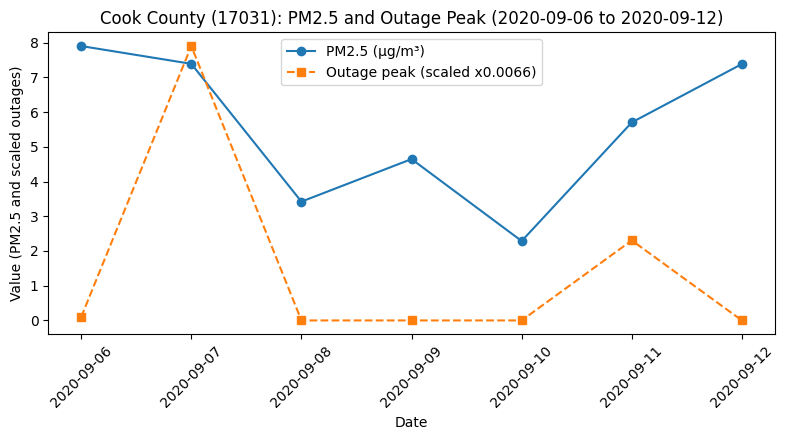

Saved figure: /workspaces/heat-smoke-grid-risk/paper/figures/pm25_outages_plot.png


In [12]:
# Cell 5: One figure — daily PM2.5 and outage peak
ts = df[["date", "pm25_mean", "cust_out_peak"]].copy().sort_values("date")

plt.figure(figsize=(8, 4.5))
# Plot PM2.5
plt.plot(ts["date"], ts["pm25_mean"], marker="o", label="PM2.5 (µg/m³)")
# Plot outage peak on a secondary axis using a simple scale to keep it on same axis
# (We avoid specifying colors to keep defaults; no seaborn.)
# Scale outages so they fit alongside PM; change scale if needed
scale = max(ts["pm25_mean"].max(), 1.0) / max(ts["cust_out_peak"].max(), 1.0) if ts["cust_out_peak"].max() > 0 else 1.0
plt.plot(ts["date"], ts["cust_out_peak"] * scale, marker="s", linestyle="--", label=f"Outage peak (scaled x{scale:.2g})")

plt.title("Cook County (17031): PM2.5 and Outage Peak (2020-09-06 to 2020-09-12)")
plt.xlabel("Date")
plt.ylabel("Value (PM2.5 and scaled outages)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

fig_path = FIG_DIR / "pm25_outages_plot.png"
plt.savefig(fig_path, dpi=150)
plt.show()

print("Saved figure:", fig_path)


Basic QA assertions

In [13]:
# Cell 6: Basic QA assertions (optional)
assert set(["fips","date","pm25_mean","share_light","share_moderate","share_heavy","cust_out_peak","cust_out_sum","total_customers","event_any"]).issubset(df.columns)

# Smoke shares in [0,1] and sum not exceeding 1
shares = df[["share_light","share_moderate","share_heavy"]].fillna(0)
assert (shares.min().min() >= 0.0) and (shares.max().max() <= 1.0)
assert (shares.sum(axis=1) <= 1.0 + 1e-9).all()

# Outage fields non-negative
for c in ["cust_out_peak","cust_out_sum","total_customers","event_any"]:
    assert (df[c] >= 0).all()

print("QA checks passed.")


QA checks passed.
